In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import listdir
from pygris import states
import geopandas as gpd
from pygris.utils import shift_geometry
from pygris import counties
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

3233


<Axes: >

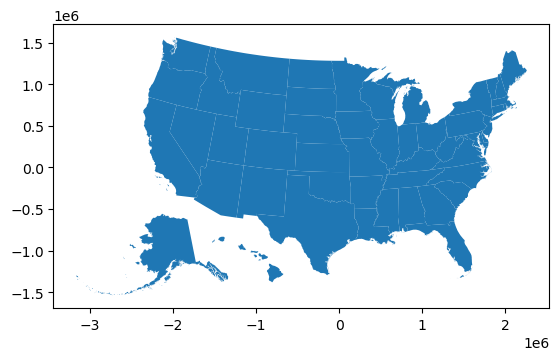

In [17]:
analysis_year = 2016 # pre-determined

us_states = states(year = analysis_year)
exclude_st = ['PR', 'GU', 'MP', 'VI', 'AS']
us_states = us_states.loc[~us_states['STUSPS'].isin(exclude_st)]
us_states = shift_geometry(us_states)

us_counties = counties(year = analysis_year)
us_counties = shift_geometry(us_counties)
print(len(us_counties))
us_states.plot()

In [5]:
scenario_name = 'national'
state_name = 'US'
input_dir = 'inputs_' + scenario_name
lodes_input = state_name + '_naics.csv'
cbp_input = 'data_emp_cbp_imputed.csv'
lodes_employment = read_csv(os.path.join(input_dir, lodes_input))
cbp_employment = read_csv(os.path.join(input_dir, cbp_input))
lodes_employment.head(5)

,GEOID,metalayer_id,n11,n21,n22,n23,n3133,n42,n4445,n4849,...,n53,n54,n55,n56,n61,n62,n71,n72,n81,n92
0,10010201001,1001020,0,0,0,30,0,0,10,1,...,3,0,0,0,155,0,0,8,8,0
1,10010202001,1001020,0,0,0,0,0,0,4,210,...,0,0,0,0,231,0,0,0,0,0
2,10010202002,1001020,0,0,41,30,21,6,50,46,...,8,48,1,4,104,26,0,55,14,618
3,10010203001,1001020,0,0,0,4,0,7,0,0,...,0,13,0,0,0,29,0,0,21,0
4,10010203002,1001020,8,0,0,0,0,0,178,0,...,48,31,0,13,0,323,14,21,8,25


In [13]:
cbp_employment.loc[:, 'COUNTY'] = \
        cbp_employment.loc[:, 'COUNTY'].astype(str).str.zfill(5)
cbp_employment.loc[:, 'industry'] = \
        cbp_employment.loc[:, 'Industry_NAICS6_CBP'].astype(str).str[0:2]
print(cbp_employment.loc[:, 'industry'].unique())

cbp_employment.loc[cbp_employment['industry'].isin(["31", "32", "33"]), 'industry'] = '3133'
cbp_employment.loc[cbp_employment['industry'].isin(["44", "45"]), 'industry'] = '4445'
cbp_employment.loc[cbp_employment['industry'].isin(["48", "49"]), 'industry'] = '4849'

cbp_employment.head(5)

['23' '11' '44' '62' '33' '42' '81' '45' '72' '22' '48' '31' '54' '71'
 '51' '53' '52' '56' '61' '55' '21' '32' '49' '92']


,Unnamed: 0,Industry_NAICS6_CBP,FAFZONE,CBPZONE,COUNTY,ZIPCODE,employment,establishment,e1,e2,e3,e4,e5,e6,e7,n2,industry
0,1,238910,19,1001,01001,36003,0.000000,1,1,0,0,0,0,0,0,23,23
1,2,113310,19,1001,01001,36003,1.930233,1,1,0,0,0,0,0,0,11,11
2,3,446110,19,1001,01001,36003,1.760684,1,1,0,0,0,0,0,0,44,4445
3,4,237110,19,1001,01001,36003,0.000000,1,1,0,0,0,0,0,0,23,23
4,5,447110,19,1001,01001,36003,6.398990,1,1,0,0,0,0,0,0,44,4445


In [28]:
cbp_employment_by_county = \
cbp_employment.groupby(['COUNTY', 'industry'])[['employment']].sum()
cbp_employment_by_county = cbp_employment_by_county.reset_index()
cbp_employment_by_county.head(5)

,COUNTY,industry,employment
0,01001,11,92.0
1,01001,21,0.0
2,01001,22,0.0
3,01001,23,194.0
4,01001,3133,0.0


In [26]:
#plot sample industry
# print(cbp_employment['Industry_NAICS6_CBP'].unique()[0:5])
naics_code = 335911
cbp_employment_sel = \
cbp_employment.loc[cbp_employment['Industry_NAICS6_CBP'] == naics_code]
cbp_employment_sel = \
cbp_employment_sel.groupby('COUNTY')[['employment', 'establishment']].sum()
cbp_employment_sel = cbp_employment_sel.reset_index()
cbp_employment_sel.rename(columns = {'COUNTY':'GEOID'}, inplace = True)
cbp_employment_sel.head(5)

,GEOID,employment,establishment
0,04013,0.0,1
1,05131,0.0,1
2,06001,51.0,4
3,06037,608.0,10
4,06059,0.0,2


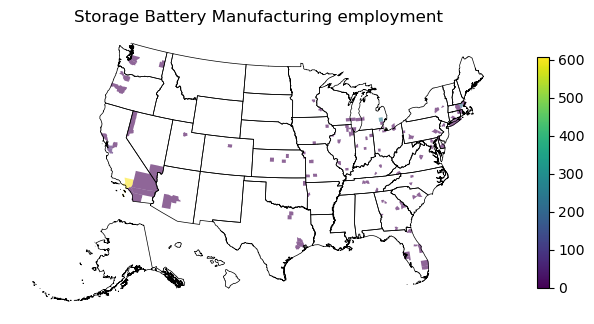

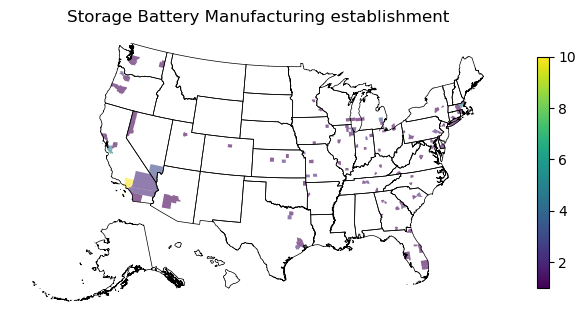

In [27]:
us_counties_to_plot = us_counties.merge(cbp_employment_sel, 
                                on = ['GEOID'], how = 'left')

industry_name_lookup = {212234: 'Copper and Nickel Mining',
                       335911: 'Storage Battery Manufacturing'}
for attr in ['employment', 'establishment']:

    ax = us_counties_to_plot.plot(column = attr,
                                cmap='viridis',
                                alpha = 0.6, 
                                linewidth=0.01, 
                                legend=True, figsize = (8,6),
                                # norm=matplotlib.colors.LogNorm(vmin=1, 
                                #                               vmax = us_counties_to_plot[vt].max()),
                                legend_kwds = {'shrink': 0.5}) 
    ind = industry_name_lookup[naics_code]
    plt.title(ind + ' ' + attr)
    us_states.plot(ax = ax, facecolor='none', edgecolor='k',linewidth = 0.5)
    # for idx, row in us_states.iterrows():
    #     centroid = row.geometry.centroid
    #     ax.annotate(text=row['state'], xy=(centroid.x, centroid.y), 
    #                 ha='center', fontsize=6)
    ax.set_axis_off()
    plt.savefig(os.path.join('plots_national', 
                              attr + '_from' + str(naics_code) + '.png'), 
                dpi = 300, bbox_inches = 'tight')
    
    plt.show()

In [7]:
lodes_employment.drop(columns = ['metalayer_id'], inplace = True)
lodes_employment.loc[:, 'GEOID'] = \
lodes_employment.loc[:, 'GEOID'].astype(str).str.zfill(12)
lodes_employment.loc[:, 'COUNTY'] = lodes_employment.loc[:, 'GEOID'].str[0:5]
lodes_employment.head(5)

,GEOID,n11,n21,n22,n23,n3133,n42,n4445,n4849,n51,...,n54,n55,n56,n61,n62,n71,n72,n81,n92,COUNTY
0,010010201001,0,0,0,30,0,0,10,1,0,...,0,0,0,155,0,0,8,8,0,01001
1,010010202001,0,0,0,0,0,0,4,210,0,...,0,0,0,231,0,0,0,0,0,01001
2,010010202002,0,0,41,30,21,6,50,46,0,...,48,1,4,104,26,0,55,14,618,01001
3,010010203001,0,0,0,4,0,7,0,0,0,...,13,0,0,0,29,0,0,21,0,01001
4,010010203002,8,0,0,0,0,0,178,0,3,...,31,0,13,0,323,14,21,8,25,01001


In [35]:
lodes_employment_long = lodes_employment.drop(columns = ['GEOID'])
lodes_employment_long = lodes_employment_long.groupby('COUNTY').sum()
lodes_employment_long = lodes_employment_long.reset_index()
lodes_employment_long = pd.melt(lodes_employment_long, id_vars = 'COUNTY', 
                                var_name='industry', value_name='employment')
lodes_employment_long = lodes_employment_long.reset_index()
lodes_employment_long.loc[:, 'industry'] = \
    lodes_employment_long.loc[:, 'industry'].str.split('n').str[1]
lodes_employment_long.head(5)

,index,COUNTY,industry,employment
0,0,01001,11,114
1,1,01003,11,858
2,2,01005,11,164
3,3,01007,11,116
4,4,01009,11,64


In [38]:
lodes_employment_long.rename(columns = {'employment': 'LEHD employment'}, 
                             inplace = True)
lodes_employment_long.drop(columns = 'index', inplace = True)
cbp_employment_by_county.rename(columns = {'employment': 'CBP employment'}, 
                             inplace = True)
employment_comparison = pd.merge(cbp_employment_by_county, lodes_employment_long,
                                on = ['COUNTY',	'industry'], how = 'outer')
# employment_comparison['employment'].fillna(0, inplace = True)
employment_comparison.head(5)

,COUNTY,industry,CBP employment,LEHD employment
0,01001,11,92.0,114.0
1,01001,21,0.0,65.0
2,01001,22,0.0,135.0
3,01001,23,194.0,511.0
4,01001,3133,0.0,1640.0


-8.768116010054653 1.7182917868885503 0.8777412672587581


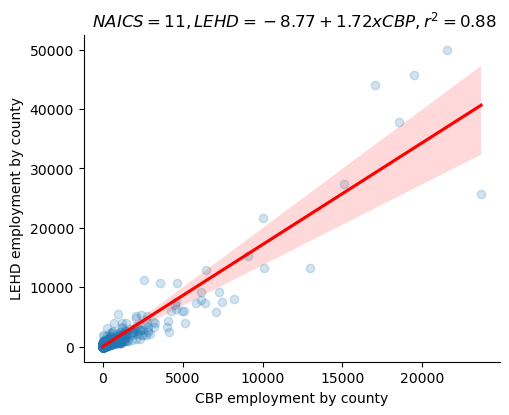

25.464807810174822 1.5399910631650273 0.9450403463631797


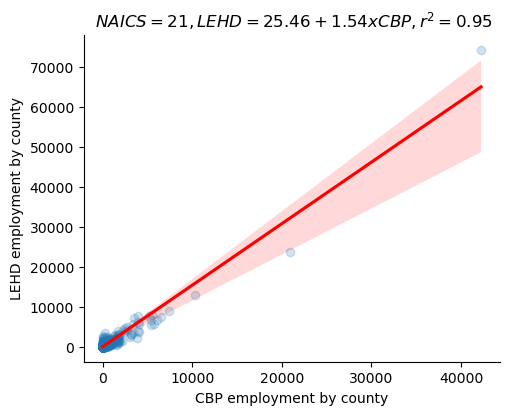

225.95226215732134 1.254869462394457 0.2264082486269352


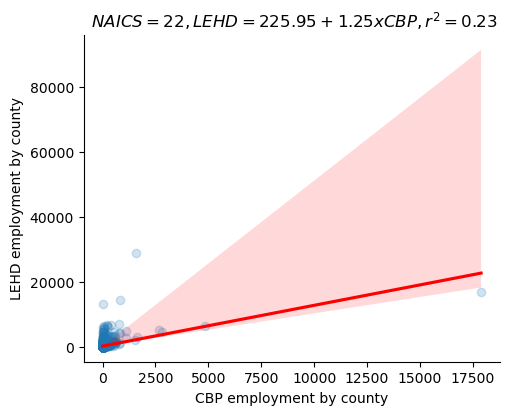

239.95002515674494 1.1134381700988667 0.9902848353522292


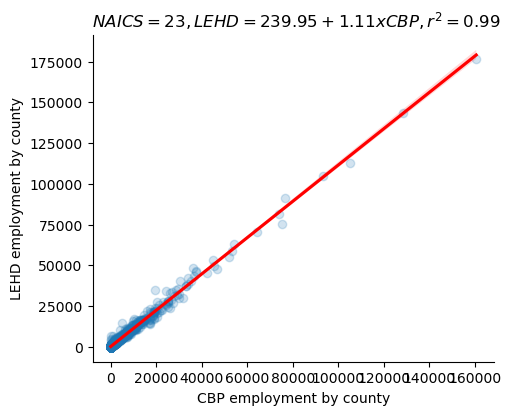

2113.2599969023413 1.2917632958420793 0.9004124860051556


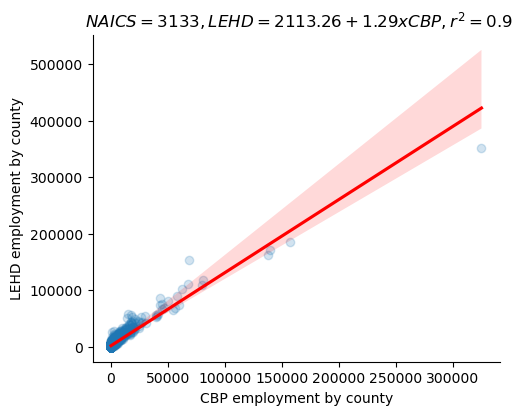

378.20130080369506 0.9844424136358967 0.9685428146753986


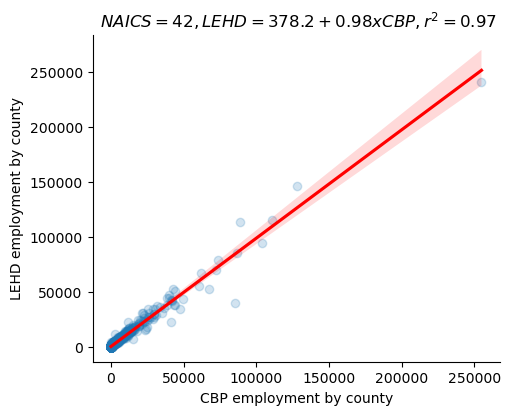

252.06250193760422 1.0974638922347648 0.9902226986707197


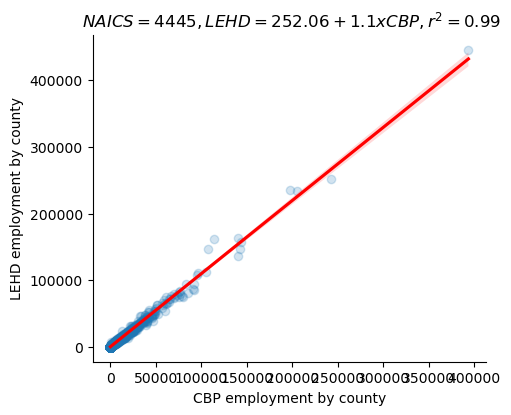

209.77069036554292 1.0661283903536944 0.9476315624415875


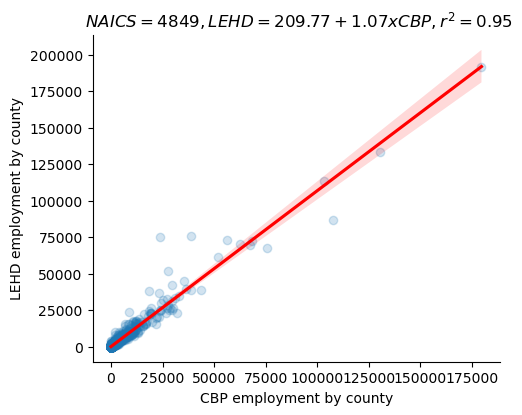

47.13722545075095 1.0197299161175097 0.9804890632604406


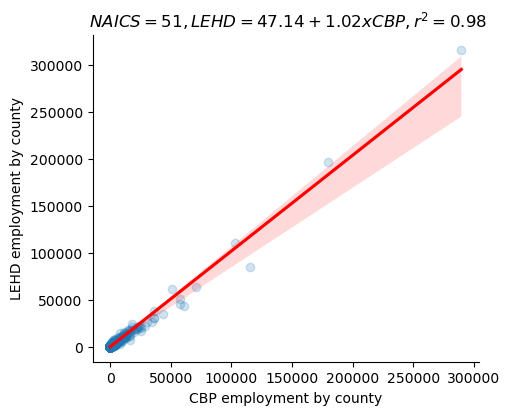

183.70415715435314 1.0062175188381532 0.9792874337642925


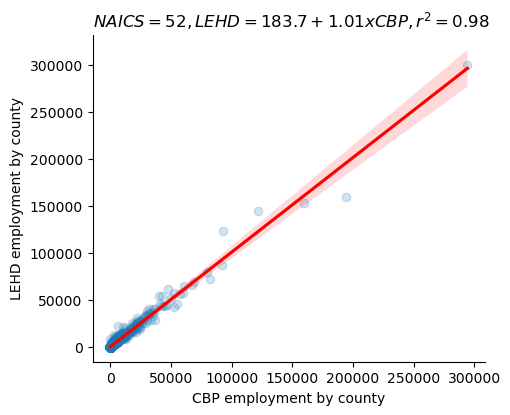

36.17353593954851 1.0868557055422028 0.9854291449665274


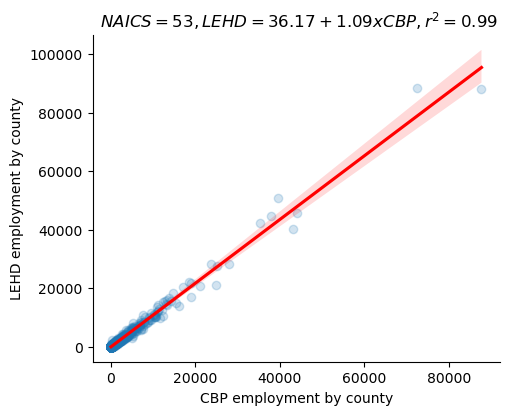

188.13797523386114 0.9530827621246905 0.9918318686787615


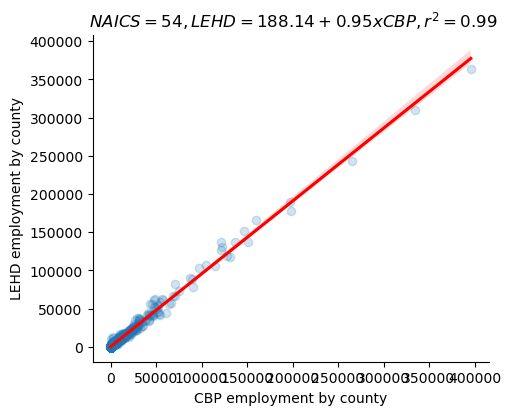

182.03575490953983 0.5764935658567163 0.834389993652538


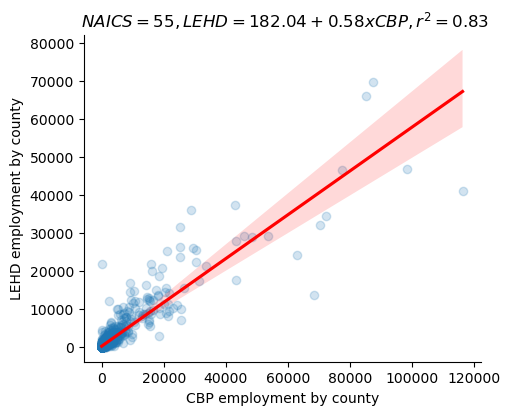

224.67409604671124 1.2391869139426566 0.9795340732357583


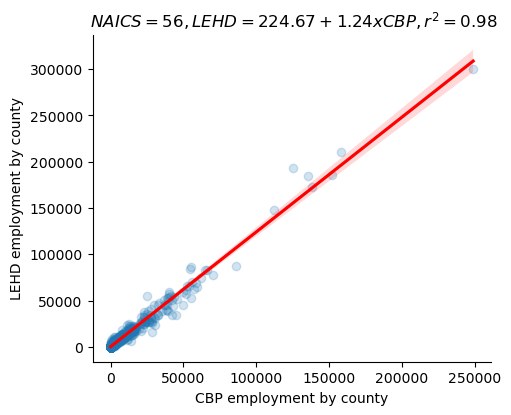

2304.1615817879574 2.0026897208736556 0.7475768719123052


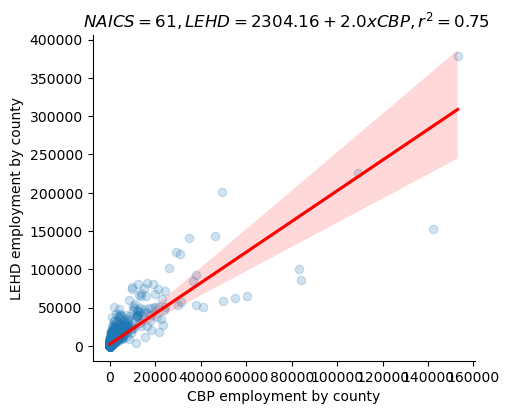

757.2945885843114 1.1542786238283478 0.9800135654898622


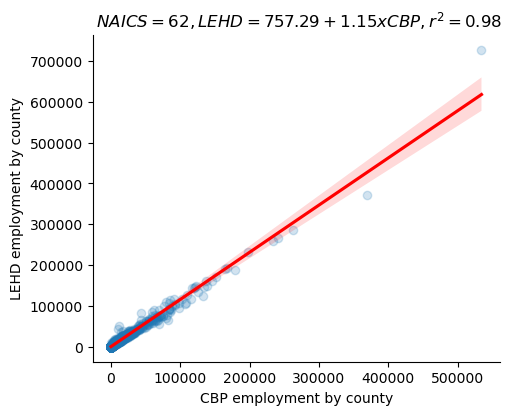

135.94161951158483 1.2224140566635278 0.9414007790669632


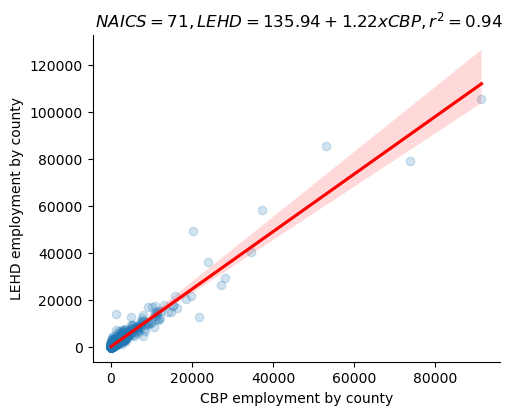

61.75681845296816 0.9976298920374385 0.9978455749727233


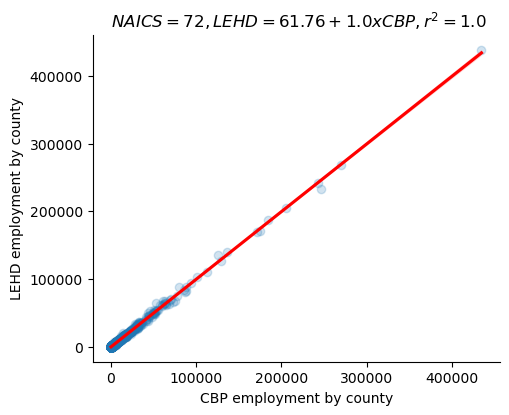

9.13644362127809 0.8342733107885719 0.9862098685959945


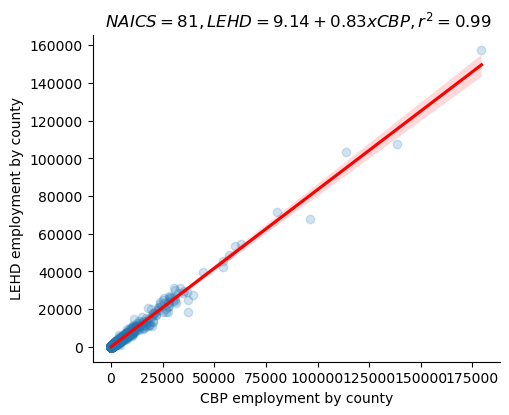

554.8951307817805 1.0845231073959323 0.8276222312487858


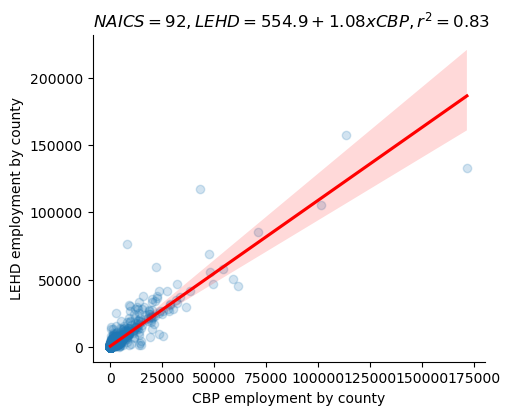

In [53]:
ind_codes = employment_comparison.industry.unique()
employment_comparison.fillna(0, inplace = True)
for ind in ind_codes:
    employment_comparison_to_plot = \
    employment_comparison.loc[employment_comparison['industry'] == ind]
    X = employment_comparison_to_plot['CBP employment']
    y = employment_comparison_to_plot['LEHD employment']
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    # print(est2.summary())
    
    lr_cons = est2.params['const']
    lr_dist = est2.params['CBP employment']
    lr_r2 = est2.rsquared
    print(lr_cons, lr_dist, lr_r2)
    
    lr_cons_short = np.round(lr_cons, 2)
    lr_dist_short = np.round(lr_dist, 2)
    lr_r2_short = np.round(lr_r2, 2)
    
    
    ax = sns.lmplot(data = employment_comparison_to_plot,
                    x="CBP employment", y="LEHD employment", 
                    scatter_kws={'alpha': 0.2},
                    line_kws={'color': 'red'},
                    height=4, aspect=1.3)
    title = f"$ \ NAICS= {ind} , LEHD={lr_cons_short} + {lr_dist_short}xCBP, r^2={lr_r2_short} $"
        # plt.legend(['y=1.1998x+2.3218', 'raw data'])
    plt.title(title)    
    plt.xlabel('CBP employment by county')
    plt.ylabel('LEHD employment by county')
    plt.savefig(os.path.join('plots_national', 
                              'LEHD_employment_comparison_for_' + ind + '.png'),
                dpi = 200, bbox_inches = 'tight')
    plt.show()
    # break

In [49]:
ind

'11'